In [1]:
###############################################################################################
# Sample price distributions typically encountered in the American Monte-Carlo (AMC) algorithm
# for XVAs. Benchmark performance of various regression methods including Machine Learning.
###############################################################################################
import numpy as np
import matplotlib.pyplot as plt
################ TODO #########################################################################
# Calculate/compare RMSEs and runtime, Display on the side of the charts
# Calculate closed-forms?
# Multi-D case with/without cross-gammas
# Generic Ensembles?
# Optimization routines for hyperparameters

In [2]:
###################### Plot Configuration #################################################
def DrawSamples(x, y):
    plt.title('Sample (' + str(nSamples) + ')')
    plt.xlabel('S(T1)')
    plt.ylabel('Payoff(T2)')
    plt.scatter(x, y, s=2, color='black', alpha=0.10)
def DrawPlot(setType, p1, l1='', p2=None, l2='', p3=None, l3=''):
    plt.plot(dispSet, p1, color='red', label=l1)
    if p2 is not None:
        plt.plot(dispSet, p2, color='blue', label=l2)
    if p3 is not None:
        plt.plot(dispSet, p3, color='green', label=l3)
    if setType == 'Training':
        plt.scatter(trainSet, trainVal, s=2, color='black', alpha=0.10)
        plt.title(modelName + ' vs Training Set (' + str(nTrain) + ')')
    else:
        plt.scatter(testSet, testVal, s=2, color='black', alpha=0.10)
        plt.title(modelName + ' vs Testing Set (' + str(nTest) + ')')
        
    plt.xlabel('S(T1)')
    plt.ylabel('Payoff(T2)')
    if p2 is not None or p3 is not None:
        plt.legend(loc='best')
def DrawResults(p1, l1='', p2=None, l2='', p3=None, l3=''):
    plt.figure(figsize=(16,4))
    plt.subplot(1,2,1)
    DrawPlot('Training', p1, l1, p2, l2, p3, l3)
    plt.subplot(1,2,2)
    DrawPlot('Testing', p1, l1, p2, l2, p3, l3)

In [3]:
###################### Generating the samples #################################################
# Pricing Inputs
dimension = 1
S0 = 100.0
vol = 0.20
T1 = 3.75 # Exposure time
T2 = 5.00 # Trade maturity
payoffType = 'C' # Call(C), Digital(DG), Straddle(ST), Butterfly(BF), Risk-Reversal(RR)
if payoffType == 'C':
    strike1 = 100.0
elif payoffType == 'ST':
    strike1 = 80.0
    strike2 = 120.0
elif payoffType == 'BF':
    strike1 = 200.0
    bfSpread = 150
elif payoffType == 'RR':
    strike1 = 100.0
    strike2 = 200.0
else: # 'DG'
    strike1 = 250.0
    smallCoupon = 2.0
    bigCoupon = 5.0

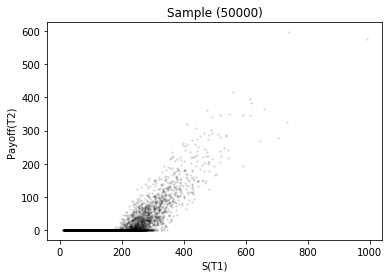

In [6]:
# Simulate samples
stDev1 = vol * np.sqrt(T1)
stDev2 = vol * np.sqrt(T2 - T1)
nSamples = 50000
rngSeed = 42
rng = np.random.RandomState(seed=rngSeed) # Mersenne-Twister
g1 = rng.normal(0.0, 1.0, nSamples)
g2 = rng.normal(0.0, 1.0, nSamples)
S1 = S0 * np.exp(-0.5 * stDev1**2 + stDev1 * g1)
S2 = S1 * np.exp(-0.5 * stDev2**2 + stDev2 * g2)
if payoffType == 'C':
    payoff = np.where(S2 > strike1, S2 - strike1, 0)
elif payoffType == 'ST':
    call = np.where(S2 > strike1, S2 - strike1, 0)
    put = np.where(S2 < strike2, strike2 - S2, 0)
    payoff = call + put 
elif payoffType == 'BF':
    long1 = np.where(S2 > strike1 - bfSpread, S2 - strike1 + bfSpread, 0)
    long2 = np.where(S2 > strike1 + bfSpread, S2 - strike1 - bfSpread, 0)
    short = np.where(S2 > strike1, S2 - strike1, 0)
    payoff =  long1 + long2 - 2 * short 
elif payoffType == 'RR':
    call = np.where(S2 > strike2, S2 - strike2, 0)
    put = np.where(S2 < strike1, strike1 - S2, 0)
    payoff = call - put
else: # 'DG'
    payoff = np.where(S2 > strike1, bigCoupon, smallCoupon)
# We will regress the payoff at T2 against the spot at T1. The regression function gives
# the expectation of the payoff at T2 conditional on the spot at T1.
# For XVAs, this allows to calculate the future exposure at T1 as a simple function of the
# variables at T1, instead of starting a nested simulation from T1.
# Plot samples
DrawSamples(S1, payoff)

In [7]:
############# Prepare for fit: Split samples intro training and test sets ##################
from sklearn.preprocessing import StandardScaler
# Split sets according to training and testing
nTrain = 25000
nTest = nSamples - nTrain
trainSet = np.ndarray(shape=(nTrain, dimension))
trainVal = np.ndarray(nTrain)
for i in range(nTrain):
    trainSet[i] = S1[i]
    trainVal[i] = payoff[i]
    
testSet = np.ndarray(shape=(nTest, dimension))
testVal = np.ndarray(nTest)
for i in range(nTest):
    testSet[i] = S1[nTrain + i]
    testVal[i] = payoff[nTrain + i]

# Rescaled sets
setScaler = StandardScaler()
trainSetRsc = setScaler.fit_transform(trainSet)
testSetRsc = setScaler.transform(testSet) # Rescale test set with training set's scaling

# Trial data for charts
m = S1.min()
M = S1.max()
nDisplay = 50
dispSet = np.ndarray(shape=(nDisplay, dimension))
for i in range(nDisplay):
    dispSet[i] = m + (M - m) * i / (nDisplay - 1)
    
dispSetRsc = setScaler.transform(dispSet) # Rescale display set with training set's scaling

print('#Training = ' + str(nTrain))
print('#Testing = ' + str(nTest))

#Training = 25000
#Testing = 25000


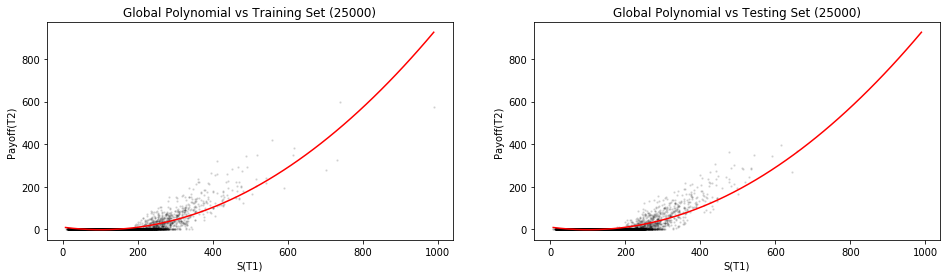

In [8]:
##################### Test Regression Methods ################################################
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
## Global Polynomials ##
modelName = 'Global Polynomial'
# Fit
polyFeats = PolynomialFeatures(degree=2)
xPoly = polyFeats.fit_transform(trainSetRsc)
globalPolyReg = linear_model.LinearRegression()
globalPolyReg.fit(xPoly, trainVal)
# Evaluate
dispPolyFeats = polyFeats.fit_transform(dispSetRsc)
dispGlobalPolyVals = globalPolyReg.predict(dispPolyFeats)
# Plot
DrawResults(dispGlobalPolyVals,'')

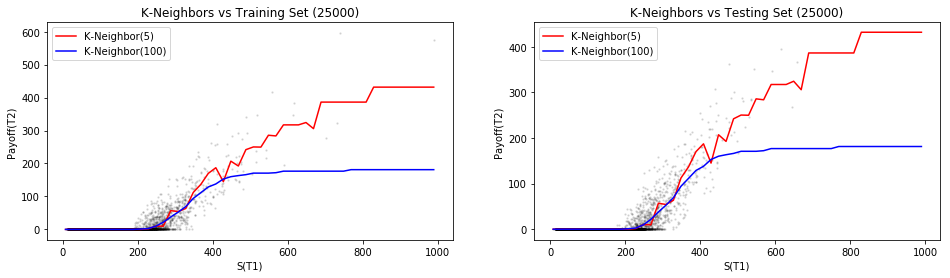

In [9]:
## K-Neighbors ##
from sklearn import neighbors
modelName = "K-Neighbors"
# Fit
nNeighbors1 = 5
nNeighbors2 = 100
kNeighborsReg1 = neighbors.KNeighborsRegressor(n_neighbors=nNeighbors1)
kNeighborsReg1.fit(xPoly, trainVal)
kNeighborsReg2 = neighbors.KNeighborsRegressor(n_neighbors=nNeighbors2)
kNeighborsReg2.fit(xPoly, trainVal)
knLabel1 = "K-Neighbor(" + str(nNeighbors1) + ")"
knLabel2 = "K-Neighbor(" + str(nNeighbors2) + ")"
# Evaluate
dispKN1Vals = kNeighborsReg1.predict(dispPolyFeats)
dispKN2Vals = kNeighborsReg2.predict(dispPolyFeats)
# Plot
DrawResults(dispKN1Vals, knLabel1, dispKN2Vals, knLabel2)

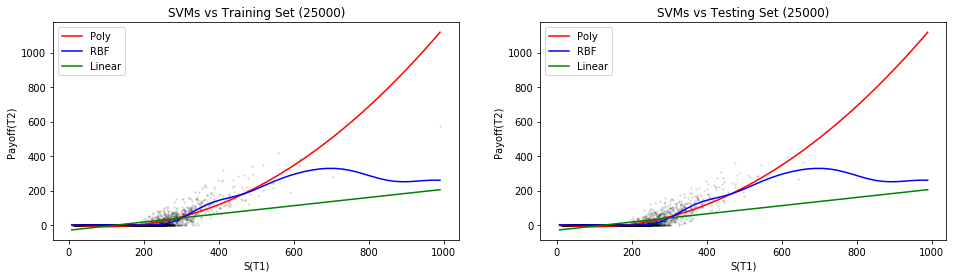

In [10]:
## Support Vector Machines (SVMs) ##
from sklearn.svm import SVR
modelName = "SVMs"
# Fit
svmRbfReg = SVR(kernel='rbf', C=100, gamma=0.2)
svmLinReg = SVR(kernel='linear', C=1, epsilon=25)
svmPolyReg = SVR(kernel="poly", degree=2, C=5, epsilon=25) # gamma='scale'
svmRbfReg.fit(trainSetRsc, trainVal)
svmLinReg.fit(trainSetRsc, trainVal)
svmPolyReg.fit(trainSetRsc, trainVal)
# Evaluate
dispSvmRBF = svmRbfReg.predict(dispSetRsc)
dispSvmLin = svmLinReg.predict(dispSetRsc)
dispSvmPoly = svmPolyReg.predict(dispSetRsc)
# Plot
DrawResults(dispSvmPoly, 'Poly', dispSvmRBF, 'RBF', dispSvmLin, 'Linear')

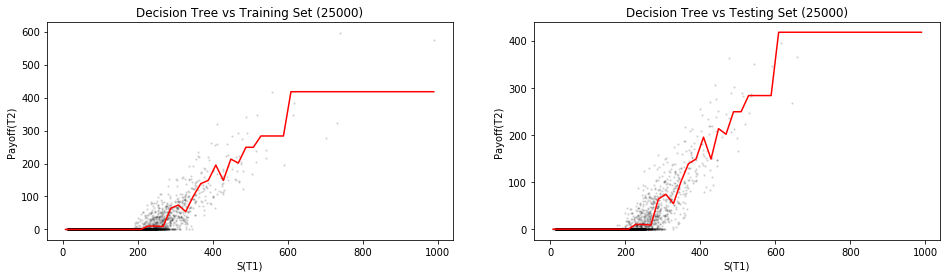

In [11]:
## Decision Trees ##
from sklearn.tree import DecisionTreeRegressor
modelName = 'Decision Tree'
# Fit
treeReg = DecisionTreeRegressor(max_depth=10, min_samples_leaf=5)
treeReg.fit(trainSetRsc, trainVal)
# Evaluate
dispTree = treeReg.predict(dispSetRsc)
# Plot
DrawResults(dispTree, 'Tree')

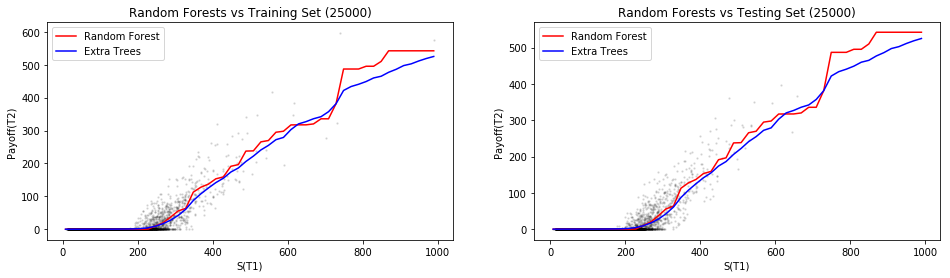

In [12]:
## Random Forests ##
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
modelName = "Random Forests"
# Fit
nEstimators = 500
nMaxLeafNodes = 8
rndForestReg = RandomForestRegressor(n_estimators=nEstimators, max_leaf_nodes=nMaxLeafNodes, n_jobs=-1)
extraTreesReg = ExtraTreesRegressor(n_estimators=nEstimators, max_leaf_nodes=nMaxLeafNodes, n_jobs=-1)
rndForestReg.fit(trainSetRsc, trainVal)
extraTreesReg.fit(trainSetRsc, trainVal)
# Evaluate
dispRndForest = rndForestReg.predict(dispSetRsc)
dispExtraTree = extraTreesReg.predict(dispSetRsc)
# Plot
DrawResults(dispRndForest, 'Random Forest', dispExtraTree, 'Extra Trees')

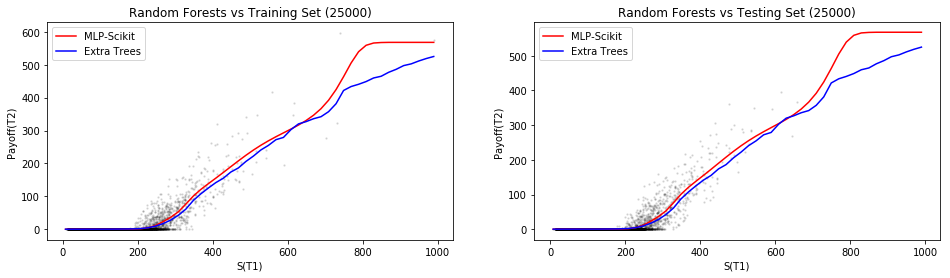

In [13]:
## Multi-Layer Perceptron (MLP) ##
from sklearn.neural_network import MLPRegressor
# Configure
hiddenLayers = (4,4,4,4,4)
activationFunction = 'tanh' # identity, logistic, tanh, or relu
solver = 'lbfgs' # lbfgs, sgd or adam
alpha = 0.1 # L2 penalty
batchSize = 50 # Mini-batch size
learningRateInit = 0.1 # initial learning rate, used for solver = 'sgd' or 'adam'
learningRate = 'constant' # constant, invscaling, or adaptive. Only used when solver = 'sgd'
randomState = 42
momentum = 0.0 # Only used for solver = 'sgd'
max_iter = 1000 # default = 200
# Fit
mlpReg = MLPRegressor(hidden_layer_sizes=hiddenLayers, activation=activationFunction, solver=solver,
                      alpha=alpha, batch_size=batchSize, learning_rate_init=learningRateInit,
                      learning_rate=learningRate, random_state=randomState, momentum=momentum,
                      validation_fraction=0)
outputScaler = StandardScaler()
mlpTrainVal = np.ndarray(shape=(nTrain,1))
for i in range(nTrain):
    mlpTrainVal[i] = trainVal[i]
mlpTrainValRsc = outputScaler.fit_transform(mlpTrainVal)
mlpTrainValRsc = mlpTrainValRsc[:,0]
mlpReg.fit(trainSetRsc, mlpTrainValRsc)
# Evaluate
outputRsc = mlpReg.predict(dispSetRsc)
dispMLPs = outputScaler.inverse_transform(outputRsc)
# Plot
DrawResults(dispMLPs, 'MLP-Scikit', dispExtraTree, 'Extra Trees')

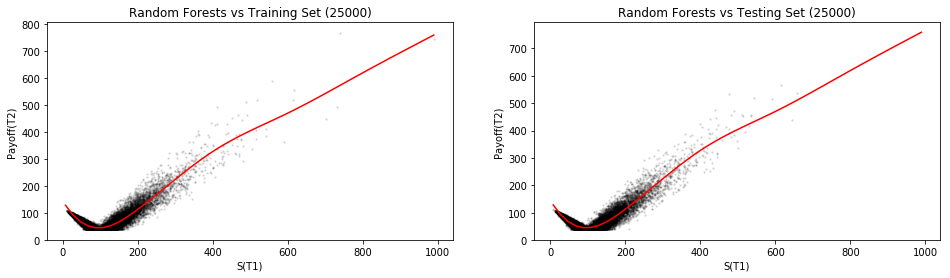

In [66]:
## Generalized Additive Models (GAMs) ##
from pygam import GAM, s, l
# Fit
gamReg = GAM(s(0, n_splines=8), link='identity', distribution='normal')
gamReg.fit(trainSetRsc, trainVal)
# Evaluate
dispGAM = gamReg.predict(dispSetRsc)
# Plot
DrawResults(dispGAM, 'GAM')

In [14]:
############## KERAS ##########################################
from keras.models import Sequential
from keras.layers import Dense

Epoch 1/30
25000/25000 [==============================] - 1s 59us/step - loss: 0.5910
Epoch 2/30
25000/25000 [==============================] - 0s 12us/step - loss: 0.4856
Epoch 3/30
25000/25000 [==============================] - 0s 12us/step - loss: 0.4808
Epoch 4/30
25000/25000 [==============================] - 0s 12us/step - loss: 0.4782
Epoch 5/30
25000/25000 [==============================] - 0s 13us/step - loss: 0.4770
Epoch 6/30
25000/25000 [==============================] - 0s 13us/step - loss: 0.4763
Epoch 7/30
25000/25000 [==============================] - 0s 11us/step - loss: 0.4760
Epoch 8/30
25000/25000 [==============================] - 0s 15us/step - loss: 0.4758
Epoch 9/30
25000/25000 [==============================] - 0s 12us/step - loss: 0.4756
Epoch 10/30
25000/25000 [==============================] - 0s 12us/step - loss: 0.4755
Epoch 11/30
25000/25000 [==============================] - 0s 12us/step - loss: 0.4754
Epoch 12/30
25000/25000 [===========================

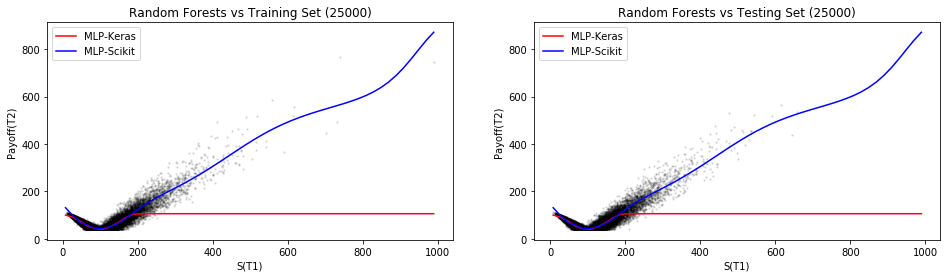

In [90]:
model = Sequential()
# Topology
model.add(Dense(10, activation='tanh', use_bias=True, input_shape=(1,)))
model.add(Dense(10, activation='relu', use_bias=True, input_shape=(1,)))
model.add(Dense(1, activation='tanh', use_bias=True))
# Fit
model.compile(loss='mean_squared_error', optimizer='nadam')
batchSize = 100
epochs = 30#int(nTrain / batchSize)
model.fit(trainSetRsc, mlpTrainValRsc, epochs=epochs, batch_size=batchSize)
# Evaluate
outputRsc = model.predict(dispSetRsc)
dispMLPk = outputScaler.inverse_transform(outputRsc)
# Plot
DrawResults(dispMLPk, 'MLP-Keras', dispMLPs, 'MLP-Scikit')